## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [210]:
import string
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(43)
torch.manual_seed(43)

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [211]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [212]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(map(str.lower, text))

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [213]:
with open('evgeniy-onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [214]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
out = "".join(map(str.lower, text))


Put all the characters, that you've seen in the text, into variable `tokens`.

In [215]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [216]:
# dict <index>:<char>
# Your great code here
idx_to_token = dict(enumerate(tokens))
# dict <char>:<index>
# Your great code here
token_to_idx = {ch: i for i, ch in idx_to_token.items()}
print(idx_to_token)
print(token_to_idx)

{0: '\n', 1: ' ', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: 'а', 13: 'б', 14: 'в', 15: 'г', 16: 'д', 17: 'е', 18: 'ж', 19: 'з', 20: 'и', 21: 'й', 22: 'к', 23: 'л', 24: 'м', 25: 'н', 26: 'о', 27: 'п', 28: 'р', 29: 'с', 30: 'т', 31: 'у', 32: 'ф', 33: 'х', 34: 'ц', 35: 'ч', 36: 'ш', 37: 'щ', 38: 'ъ', 39: 'ы', 40: 'ь', 41: 'э', 42: 'ю', 43: 'я'}
{'\n': 0, ' ': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'а': 12, 'б': 13, 'в': 14, 'г': 15, 'д': 16, 'е': 17, 'ж': 18, 'з': 19, 'и': 20, 'й': 21, 'к': 22, 'л': 23, 'м': 24, 'н': 25, 'о': 26, 'п': 27, 'р': 28, 'с': 29, 'т': 30, 'у': 31, 'ф': 32, 'х': 33, 'ц': 34, 'ч': 35, 'ш': 36, 'щ': 37, 'ъ': 38, 'ы': 39, 'ь': 40, 'э': 41, 'ю': 42, 'я': 43}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [217]:
# Your code here
class VanillaRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size = 128):
        super(VanillaRNN, self).__init__()
        self.hs_size = hidden_size

        self.embedding = nn.Embedding(input_size, self.hs_size)
        self.base_rnn = nn.RNN(self.hs_size, self.hs_size, 1, batch_first=True)
        self.final_layer = nn.Linear(self.hs_size, output_size)

    def forward(self, x, hs):
        
        embedded_data = self.embedding(x)
        output, hs = self.base_rnn(embedded_data, hs)
        output = self.final_layer(output.view(-1, self.hs_size))
        return output, hs

    def initial_state(self):
        return torch.zeros(1, 1, self.hs_size)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [218]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = token_to_idx[string[c]]
    return tensor

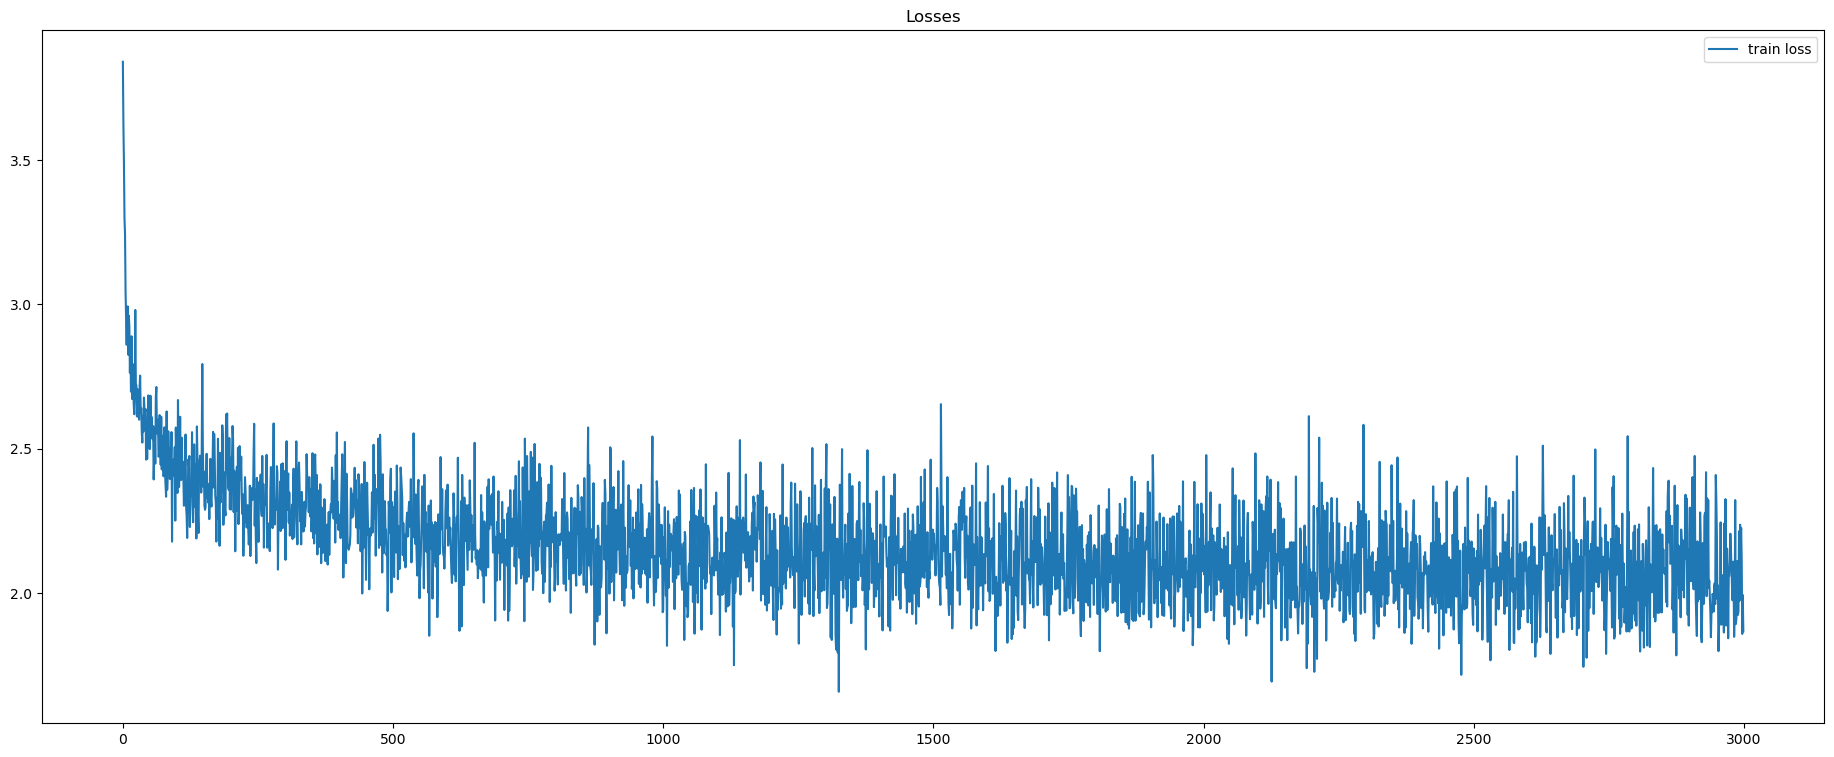

In [219]:
# Your plot code here
model = VanillaRNN(input_size=len(tokens), output_size=len(tokens))
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

n_epochs = 3000
seq_len = 200
losses = []

model.train()

for epoch in range(n_epochs):
    inp = torch.zeros(1, seq_len).long()
    target = torch.zeros(1, seq_len).long()
    start_index = np.random.randint(0, len(out) - seq_len)
    end_index = start_index + seq_len + 1
    seq = out[start_index:end_index]
    inp[0] = char_tensor(seq[:-1])
    target[0] = char_tensor(seq[1:])
    hs = model.initial_state()
    model.zero_grad()
    loss = 0
    for c in range(inp.shape[0]):
        output, hs = model(inp[c].unsqueeze(0), hs)
        loss += loss_func(output, target[c])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

fig, p1 = plt.subplots(1, 1, figsize=(23, 9))

p1.set_title('Losses')
p1.plot(losses, label='train loss')
p1.legend()

In [220]:
MAX_LENGTH = 100

In [221]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state()
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        output, hid_state = char_rnn(x_sequence[:, i].unsqueeze(0), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        output, hid_state = char_rnn(x_sequence[:, -1].unsqueeze(0), hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(output / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [222]:
# An example of generated text.
model.eval()
print(generate_sample(char_rnn=model, seed_phrase='молодая', max_length=100, temperature=0.2))

молодая полова
не последной он и пославанье
в сегоненье
на пославанья
не пославанья
и послажденье
в 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [223]:
# Your beautiful code here
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, 1, batch_first=True)
        self.final_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, hs):
        embedded = self.embedding(x)
        output, hs = self.lstm(embedded, hs)
        output = self.final_layer(output.view(-1, self.hidden_size))
        return output, hs

    def initial_state(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

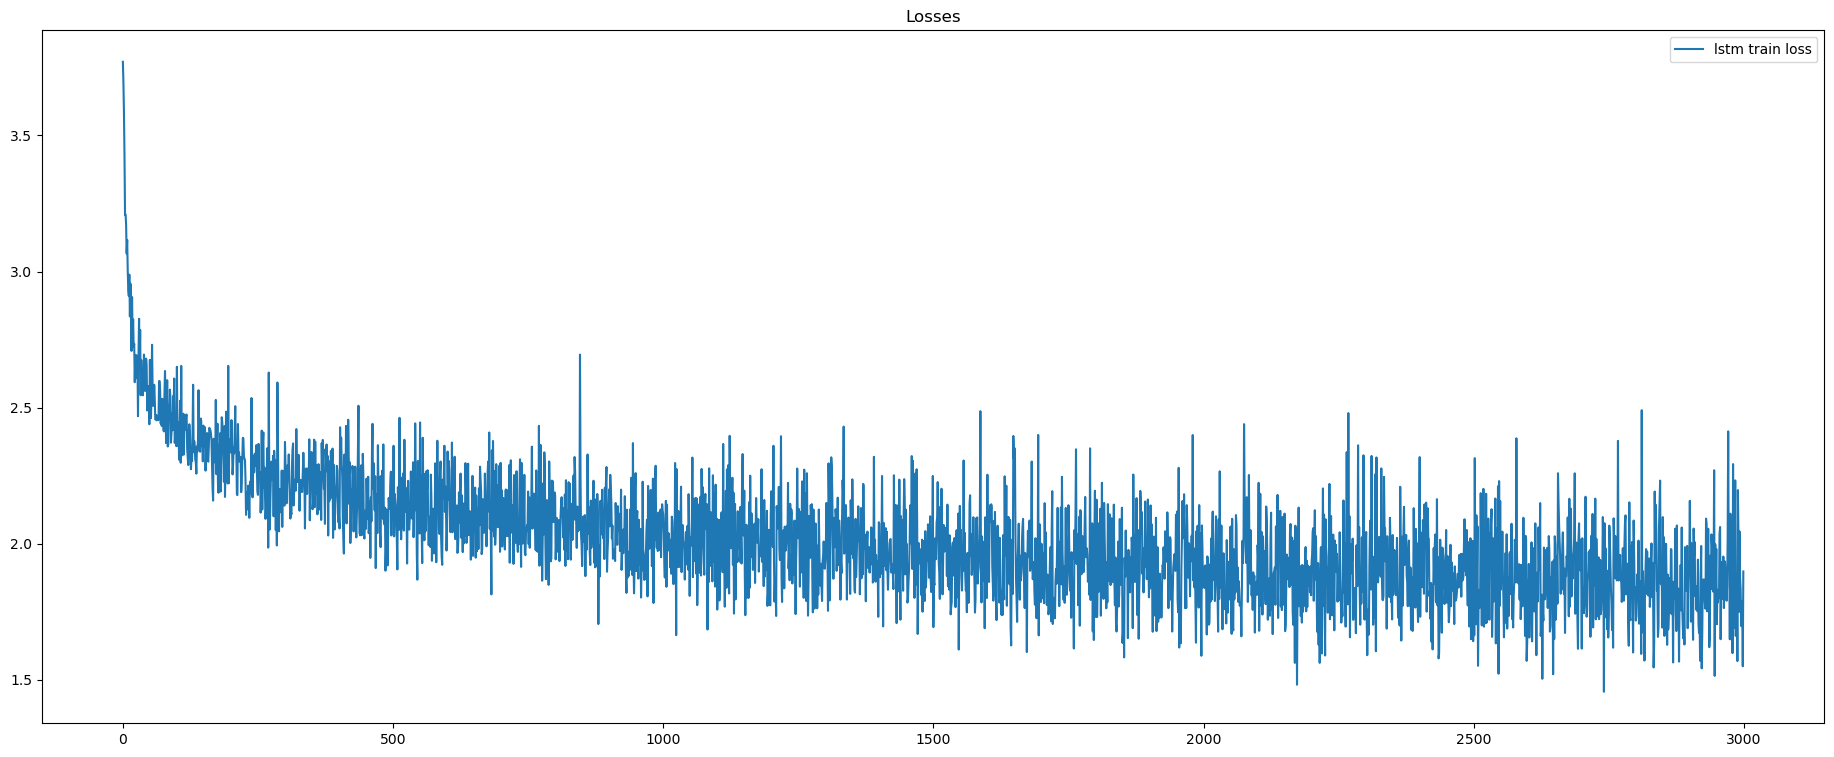

In [224]:
lstm_model = LSTMModel(input_size=len(tokens), hidden_size=128, output_size=len(tokens))
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.005)

hidden_state = lstm_model.initial_state()

lstm_losses = []
lstm_model.train()
for epoch in range(n_epochs):
    inp = torch.zeros(1, seq_len).long()
    target = torch.zeros(1, seq_len).long()
    start_index = np.random.randint(0, len(out) - seq_len)
    end_index = start_index + seq_len + 1
    seq = out[start_index:end_index]
    inp[0] = char_tensor(seq[:-1])
    target[0] = char_tensor(seq[1:])
    
    lstm_model.zero_grad()
    loss = 0

    hidden_state = tuple([h.detach() for h in hidden_state])

    output, hidden_state = lstm_model(inp, hidden_state)
    loss = loss_func(output.view(-1, len(tokens)), target.squeeze().view(-1))
    loss.backward()

    optimizer.step()
    lstm_losses.append(loss.item())


fig, p1 = plt.subplots(1, 1, figsize=(23, 9))

p1.set_title('Losses')
p1.plot(lstm_losses, label='lstm train loss')
p1.legend()


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [225]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
lstm_model.eval()
for t in temperatures:
    print()
    print(f"(^_^) Temperature: {t} (^_^)")
    generated_text = generate_sample(lstm_model, seed_phrase='своей', max_length=100, temperature=t)
    print(generated_text)


(^_^) Temperature: 0.1 (^_^)
своей
и все все в света в своей делать и в собой
все все в своей делать и в сердце в свет
и в сердце

(^_^) Temperature: 0.2 (^_^)
своей
и ветренит в ней в ней не вольной
и в собой делать нас в делать и вольный
и под не все приводи

(^_^) Temperature: 0.5 (^_^)
своей
отворят больно в подобный
под давно в только с идит
и в станит делаки верилась
в том и гробовь

(^_^) Temperature: 1.0 (^_^)
своей
укой восписатный правидке
и может постетык еге выпор352
зваден что ожимит
кому плеществериц на

(^_^) Temperature: 2.0 (^_^)
своей4би
ем фарленю ал улдержает
поэт вармугникостутверч
т тыуритак
стобель бысхатчно рылая
иуж3лиц2


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [226]:
# Saving and loading code here
torch.save(lstm_model, './lstm_model.pth')
model_loaded = torch.load('./lstm_model.pth')
print(generate_sample(model_loaded, seed_phrase='своей', max_length=100, temperature=0.3))

своей
столит в ней все милые страх
и не стране под не выскойный
вот не в своей подушный не в старин



### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)